# ***Problem Statement: Predicting the likelihood of fraudulent providers in Georgia hospitals.***


# Import our dependencies and datasets

In [ ]:
# dependencies
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,roc_curve,accuracy_score,roc_auc_score,classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.calibration import CalibratedClassifierCV
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

In [ ]:
# train datasets for patient info
train_beneficiary_data = pd.read_csv("Train_Beneficiarydata-1542865627584.csv")
train_inpatient_data = pd.read_csv("Train_Inpatientdata-1542865627584.csv")

# test datasets for patient info
test_beneficiary_data = pd.read_csv("Test_Beneficiarydata-1542969243754.csv")
test_inpatient_data = pd.read_csv("Test_Inpatientdata-1542969243754.csv")

# main train dataset
train_data = pd.read_csv("Train-1542865627584.csv")

# main test dataset
test_data = pd.read_csv("Test-1542969243754.csv")

# Clean the data

In [ ]:
# after analyzing the main train dataset (train_data), we noticed that the 
# "PotentialFraud" column is "Yes" and "No". Before we begin modeling we want to 
# change Yes to 1 and No to 1
train_data['PotentialFraud'] = train_data['PotentialFraud'].map({'Yes': 1, 'No': 0})
train_data

,Provider,PotentialFraud
0,PRV51001,0
1,PRV51003,1
2,PRV51004,0
3,PRV51005,1
4,PRV51007,0
...,...,...
5405,PRV57759,0
5406,PRV57760,0
5407,PRV57761,0
5408,PRV57762,0


In [ ]:
# preview data (train_beneficiary_data)
train_beneficiary_data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11002,1936-09-01,NaN,2,1,0,39,280,12,12,2,2,2,2,2,2,2,2,2,2,2,0,0,30,50
2,BENE11003,1936-08-01,NaN,1,1,0,52,590,12,12,1,2,2,2,2,2,2,1,2,2,2,0,0,90,40
3,BENE11004,1922-07-01,NaN,1,1,0,39,270,12,12,1,1,2,2,2,2,1,1,1,1,2,0,0,1810,760
4,BENE11005,1935-09-01,NaN,1,1,0,24,680,12,12,2,2,2,2,1,2,1,2,2,2,2,0,0,1790,1200


In [ ]:
# since we're only focusing on Georgia, we only want patient info where state = 10
# 10 because the states are numbered in chronological order
train_beneficiary_grouped = train_beneficiary_data.loc[train_beneficiary_data["State"] == 10, :]

# train_beneficiary_data - create a new dataframe because we want to drop unnecessary columns
train_beneficiary_df = pd.DataFrame({
    "BeneID": train_beneficiary_grouped["BeneID"],
    "DOB": train_beneficiary_grouped["DOB"],
    "Gender": train_beneficiary_grouped["Gender"],
    "Race": train_beneficiary_grouped["Race"],
    "State": train_beneficiary_grouped["State"]
})
train_beneficiary_df.head()

,BeneID,DOB,Gender,Race,State
27,BENE11029,1928-12-01,1,5,10
37,BENE11041,1922-10-01,2,1,10
55,BENE11059,1948-12-01,1,1,10
71,BENE11075,1925-09-01,2,1,10
73,BENE11077,1938-03-01,2,5,10


In [ ]:
# preview data (train_inpatient_data)
train_inpatient_data.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,PHY318495,PHY318495,NaN,2009-08-31,6186,1068.0,2009-09-02,750,6186,2948,56400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7092.0,NaN,NaN,NaN,NaN,NaN
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,PHY372395,NaN,PHY324689,2009-09-17,29590,1068.0,2009-09-20,883,29623,30390,71690,34590,V1581,32723,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,PHY369659,PHY392961,PHY349768,2009-02-14,431,1068.0,2009-02-22,067,43491,2762,7843,32723,V1041,4254,25062,40390,4019,NaN,331.0,NaN,NaN,NaN,NaN,NaN
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,PHY379376,PHY398258,NaN,2009-08-13,78321,1068.0,2009-08-30,975,042,3051,34400,5856,42732,486,5119,29620,20300,NaN,3893.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# train_inpatient_data - create a new dataframe because we want to drop unnecessary columns
train_inpatient_df = pd.DataFrame({
  "BeneID": train_inpatient_data["BeneID"],
  "ClaimID": train_inpatient_data["ClaimID"],
  "ClaimStartDt": train_inpatient_data["ClaimStartDt"],
  "ClaimEndDt": train_inpatient_data["ClaimEndDt"],
  "Provider": train_inpatient_data["Provider"],
  "InscClaimAmtReimbursed": train_inpatient_data["InscClaimAmtReimbursed"], 
  "ClmAdmitDiagnosisCode": train_inpatient_data["ClmAdmitDiagnosisCode"],
  "DiagnosisGroupCode": train_inpatient_data['DiagnosisGroupCode']
})
train_inpatient_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode
0,BENE11001,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,7866,201
1,BENE11001,CLM66048,2009-08-31,2009-09-02,PRV55907,5000,6186,750
2,BENE11001,CLM68358,2009-09-17,2009-09-20,PRV56046,5000,29590,883
3,BENE11011,CLM38412,2009-02-14,2009-02-22,PRV52405,5000,431,067
4,BENE11014,CLM63689,2009-08-13,2009-08-30,PRV56614,10000,78321,975


In [ ]:
# preview data (test_beneficiary_data)
test_beneficiary_data.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70
1,BENE11007,1940-09-01,2009-12-01,1,2,0,45,610,12,12,1,1,2,2,2,2,1,2,1,1,2,0,0,1490,160
2,BENE11010,1936-07-01,NaN,2,1,0,41,30,12,12,2,1,2,1,1,2,1,1,1,2,2,0,0,1170,660
3,BENE11011,1914-03-01,NaN,2,2,0,1,360,12,12,2,1,1,2,2,1,1,2,2,1,1,5000,1068,250,320
4,BENE11014,1938-04-01,NaN,2,1,Y,45,780,12,12,2,1,1,2,1,1,2,1,2,2,2,21260,2136,120,100


In [ ]:
# since we're only focusing on Georgia, we only want patient info where state = 10
# 10 because the states are numbered in chronological order
test_beneficiary_grouped = test_beneficiary_data.loc[test_beneficiary_data["State"] == 10, :]

# test_beneficiary_data - create a new dataframe because we want to drop unnecessary columns
test_beneficiary_df = pd.DataFrame({
    "BeneID": test_beneficiary_grouped["BeneID"],
    "DOB": test_beneficiary_grouped["DOB"],
    "Gender": test_beneficiary_grouped["Gender"],
    "Race": test_beneficiary_grouped["Race"],
    "State": test_beneficiary_grouped["State"]
})
test_beneficiary_df.head()

,BeneID,DOB,Gender,Race,State
10,BENE11029,1928-12-01,1,5,10
14,BENE11041,1922-10-01,2,1,10
23,BENE11059,1948-12-01,1,1,10
31,BENE11075,1925-09-01,2,1,10
32,BENE11077,1938-03-01,2,5,10


In [ ]:
# preview data (test_inpatientdata_data)
test_inpatient_data.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000,PHY317786,PHY427017,NaN,2009-09-09,5789,1068.0,2009-09-16,332,5780,5533,496,V420,40390,2851,5990,570,41071,4280,4443.0,5849.0,NaN,NaN,NaN,NaN
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000,PHY314656,PHY426644,NaN,2008-12-25,5939,1068.0,2009-01-08,661,1889,41071,5990,5601,4588,5845,4549,29570,34831,NaN,5551.0,NaN,NaN,NaN,NaN,NaN
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000,PHY349495,NaN,NaN,2009-12-09,4019,1068.0,2009-12-13,241,4010,78791,60000,41401,V1254,4372,78650,7813,4254,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000,PHY429538,PHY371893,NaN,2009-06-23,8208,1068.0,2009-07-06,564,8208,4168,920,5990,40391,2859,4254,41400,5849,41401,8152.0,3320.0,NaN,NaN,NaN,NaN
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000,PHY397161,NaN,NaN,2009-01-20,4279,1068.0,2009-01-31,880,29654,V142,78702,30503,V140,V4582,V6109,7242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# test_inpatient_data - create a new dataframe because we want to drop unnecessary columns
test_inpatient_df = pd.DataFrame({
  "BeneID": test_inpatient_data["BeneID"],
  "ClaimID": test_inpatient_data["ClaimID"],
  "ClaimStartDt": test_inpatient_data["ClaimStartDt"],
  "ClaimEndDt": test_inpatient_data["ClaimEndDt"],
  "Provider": test_inpatient_data["Provider"],
  "InscClaimAmtReimbursed": test_inpatient_data["InscClaimAmtReimbursed"], 
  "ClmAdmitDiagnosisCode": test_inpatient_data["ClmAdmitDiagnosisCode"],
  "DiagnosisGroupCode": train_inpatient_data['DiagnosisGroupCode']
})
test_inpatient_df.head()

,BeneID,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode
0,BENE11014,CLM67387,2009-09-09,2009-09-16,PRV57070,9000.0,5789,201
1,BENE11017,CLM31237,2008-12-25,2009-01-08,PRV54750,14000.0,5939,750
2,BENE11026,CLM78930,2009-12-09,2009-12-13,PRV53758,2000.0,4019,883
3,BENE11031,CLM56810,2009-06-23,2009-07-06,PRV55825,16000.0,8208,067
4,BENE11085,CLM34625,2009-01-20,2009-01-31,PRV52338,19000.0,4279,975


# Merge datasets (train with train and test with test)
We want to be able to provide an overall consensus of the probability of fradulent healthcare providers and have all patient information in a single dataframe

In [ ]:
# merge train datasets
train_patient_df = pd.merge(train_beneficiary_df, train_inpatient_df, on="BeneID")
train_patient_df.head()

,BeneID,DOB,Gender,Race,State,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode
0,BENE11041,1922-10-01,2,1,10,CLM54944,2009-06-10,2009-06-15,PRV52283,6000,49121,202
1,BENE11041,1922-10-01,2,1,10,CLM78682,2009-12-07,2009-12-13,PRV52283,17000,51881,165
2,BENE11185,1918-06-01,2,1,10,CLM35019,2009-01-22,2009-01-24,PRV52178,4000,2512,637
3,BENE11185,1918-06-01,2,1,10,CLM38541,2009-02-15,2009-02-16,PRV52173,6000,43310,102
4,BENE11202,1939-11-01,2,1,10,CLM62377,2009-08-03,2009-08-10,PRV52280,24000,4111,241


In [ ]:
# merge test datasets
test_patient_df = pd.merge(test_beneficiary_df, test_inpatient_df, on="BeneID")
test_patient_df.head()

,BeneID,DOB,Gender,Race,State,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode
0,BENE11852,1940-06-01,1,1,10,CLM36399,2009-02-01,2009-02-06,PRV52116,20000.0,4280,175
1,BENE11961,1927-08-01,1,1,10,CLM38196,2009-02-13,2009-02-14,PRV52117,17000.0,4414,535
2,BENE11998,1938-04-01,1,1,10,CLM68084,2009-09-15,2009-09-17,PRV53866,4000.0,1748,986
3,BENE12939,1935-08-01,2,1,10,CLM39646,2009-02-23,2009-02-26,PRV52078,10000.0,4280,311
4,BENE13133,1931-02-01,1,1,10,CLM63758,2009-08-14,2009-08-16,PRV52287,0.0,78650,281


# Exploratory Data Analysis - train_patient_df



In [ ]:
# use .info() to get overall summary of data
train_patient_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3056 entries, 0 to 3055
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   BeneID                  3056 non-null   object
 1   DOB                     3056 non-null   object
 2   Gender                  3056 non-null   int64 
 3   Race                    3056 non-null   int64 
 4   State                   3056 non-null   int64 
 5   ClaimID                 3056 non-null   object
 6   ClaimStartDt            3056 non-null   object
 7   ClaimEndDt              3056 non-null   object
 8   Provider                3056 non-null   object
 9   InscClaimAmtReimbursed  3056 non-null   int64 
 10  ClmAdmitDiagnosisCode   3056 non-null   object
 11  DiagnosisGroupCode      3056 non-null   object
dtypes: int64(4), object(8)
memory usage: 310.4+ KB


In [ ]:
# we need to change ClmAdmitDiagnosisCode and DiagnosisGroupCode variable from string to int for modelling
train_patient_df['ClmAdmitDiagnosisCode'] = pd.to_numeric(train_patient_df['ClmAdmitDiagnosisCode'], errors='coerce')
train_patient_df['DiagnosisGroupCode'] = pd.to_numeric(train_patient_df['DiagnosisGroupCode'], errors='coerce')

# verify data type has been changed
print(train_patient_df['ClmAdmitDiagnosisCode'].dtypes)
print(train_patient_df['DiagnosisGroupCode'].dtypes)

float64
float64


In [ ]:
# count number of null values present
train_patient_df.isnull().sum()

BeneID                      0
DOB                         0
Gender                      0
Race                        0
State                       0
ClaimID                     0
ClaimStartDt                0
ClaimEndDt                  0
Provider                    0
InscClaimAmtReimbursed      0
ClmAdmitDiagnosisCode     103
DiagnosisGroupCode          8
dtype: int64

In [ ]:
# since we added "errors = 'coerce'" to our pd.to_numeric function when changing 
# ClmAdmitDiagnosisCode and DiagnosisGroupCode, values that produced an error were changed to null values. 
# dropping these null values
train_patient_df = train_patient_df.dropna(axis = 0)

# verify null values were dropped
train_patient_df.isnull().sum()

BeneID                    0
DOB                       0
Gender                    0
Race                      0
State                     0
ClaimID                   0
ClaimStartDt              0
ClaimEndDt                0
Provider                  0
InscClaimAmtReimbursed    0
ClmAdmitDiagnosisCode     0
DiagnosisGroupCode        0
dtype: int64

# Exploratory Data Analysis - test_patient_df

In [ ]:
# use .info() to get overall summary of data
test_patient_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 454 entries, 0 to 453
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   BeneID                  454 non-null    object 
 1   DOB                     454 non-null    object 
 2   Gender                  454 non-null    int64  
 3   Race                    454 non-null    int64  
 4   State                   454 non-null    int64  
 5   ClaimID                 454 non-null    object 
 6   ClaimStartDt            454 non-null    object 
 7   ClaimEndDt              454 non-null    object 
 8   Provider                454 non-null    object 
 9   InscClaimAmtReimbursed  454 non-null    float64
 10  ClmAdmitDiagnosisCode   454 non-null    object 
 11  DiagnosisGroupCode      454 non-null    object 
dtypes: float64(1), int64(3), object(8)
memory usage: 46.1+ KB


In [ ]:
# we need to change ClmAdmitDiagnosisCode and DiagnosisGroupCode variable from string to int for modelling
test_patient_df['ClmAdmitDiagnosisCode'] = pd.to_numeric(test_patient_df['ClmAdmitDiagnosisCode'], errors='coerce')
test_patient_df['DiagnosisGroupCode'] = pd.to_numeric(test_patient_df['DiagnosisGroupCode'], errors='coerce')

# verify data type has been changed
print(test_patient_df['ClmAdmitDiagnosisCode'].dtypes)
print(test_patient_df['DiagnosisGroupCode'].dtypes)

float64
float64


In [ ]:
# confirm we still have no null values
test_patient_df.isnull().sum()

BeneID                     0
DOB                        0
Gender                     0
Race                       0
State                      0
ClaimID                    0
ClaimStartDt               0
ClaimEndDt                 0
Provider                   0
InscClaimAmtReimbursed     0
ClmAdmitDiagnosisCode     16
DiagnosisGroupCode         2
dtype: int64

In [ ]:
# since we added "errors = 'coerce'" to our pd.to_numeric function when changing 
# ClmAdmitDiagnosisCode and DiagnosisGroupCode, values that produced an error were changed to null values. 
# dropping these null values
test_patient_df = test_patient_df.dropna(axis = 0)

# verify null values were dropped
test_patient_df.isnull().sum()

BeneID                    0
DOB                       0
Gender                    0
Race                      0
State                     0
ClaimID                   0
ClaimStartDt              0
ClaimEndDt                0
Provider                  0
InscClaimAmtReimbursed    0
ClmAdmitDiagnosisCode     0
DiagnosisGroupCode        0
dtype: int64

# Merge final datasets together for modelling

In [ ]:
# here we're merging our train dataset containing patient info with our main train dataset to prepare for modelling
final_train = pd.merge(train_patient_df, train_data, on = "Provider", how = 'left')
final_train

,BeneID,DOB,Gender,Race,State,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode,PotentialFraud
0,BENE11041,19221001,2,1,10,CLM54944,20090610,20090610,PRV52283,6000,49121.0,202.0,1
1,BENE11041,19221001,2,1,10,CLM78682,20091207,20091207,PRV52283,17000,51881.0,165.0,1
2,BENE11185,19180601,2,1,10,CLM35019,20090122,20090122,PRV52178,4000,2512.0,637.0,1
3,BENE11185,19180601,2,1,10,CLM38541,20090215,20090215,PRV52173,6000,43310.0,102.0,1
4,BENE11202,19391101,2,1,10,CLM62377,20090803,20090803,PRV52280,24000,4111.0,241.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2940,BENE158482,19281101,1,1,10,CLM71147,20091007,20091007,PRV52063,4000,49121.0,206.0,0
2941,BENE158790,19310901,1,1,10,CLM80833,20091226,20091226,PRV52135,12000,78097.0,864.0,1
2942,BENE158891,19230401,2,1,10,CLM42114,20090311,20090311,PRV52151,30000,99604.0,299.0,1
2943,BENE158975,19430901,1,1,10,CLM35740,20090127,20090127,PRV54743,18000,71531.0,512.0,1


In [ ]:
# here we're merging our test dataset containing patient info with our main test dataset to prepare for modelling
final_test = pd.merge(test_patient_df, test_data, on = "Provider", how = 'left')
final_test

,BeneID,DOB,Gender,Race,State,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode
0,BENE11852,19400601,1,1,10,CLM36399,20090201,20090201,PRV52116,20000.0,4280.0,175.0
1,BENE11961,19270801,1,1,10,CLM38196,20090213,20090213,PRV52117,17000.0,4414.0,535.0
2,BENE11998,19380401,1,1,10,CLM68084,20090915,20090915,PRV53866,4000.0,1748.0,986.0
3,BENE12939,19350801,2,1,10,CLM39646,20090223,20090223,PRV52078,10000.0,4280.0,311.0
4,BENE13133,19310201,1,1,10,CLM63758,20090814,20090814,PRV52287,0.0,78650.0,281.0
...,...,...,...,...,...,...,...,...,...,...,...,...
431,BENE157706,19360301,2,1,10,CLM40479,20090228,20090228,PRV52078,7000.0,42732.0,463.0
432,BENE157781,19310201,1,1,10,CLM58223,20090703,20090703,PRV51955,10000.0,44024.0,314.0
433,BENE158067,19390601,2,1,10,CLM50850,20090512,20090512,PRV52137,7000.0,2113.0,693.0
434,BENE158342,19431201,2,1,10,CLM53021,20090527,20090527,PRV54980,0.0,42731.0,208.0


# Model our predictions using Machine Learning


In [ ]:
# shape of final datasets
print("Shape of final train dataset: ", final_train.shape)
print("Shape of final test dataset", final_test.shape)

Shape of final train dataset:  (2945, 13)
Shape of final test dataset (436, 12)


In [ ]:
# dropping "ID" variables in train set as these will not provide any patterns for us and will not be 
# beneficial for our models since we're trying to train a model to understand general patterns
del final_train['Provider']
del final_train['BeneID']
del final_train['ClaimID']
del final_train['ClaimStartDt']
del final_train['ClaimEndDt']
del final_train['DOB']
final_train

,Gender,Race,State,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode,PotentialFraud
0,2,1,10,6000,49121.0,202.0,1
1,2,1,10,17000,51881.0,165.0,1
2,2,1,10,4000,2512.0,637.0,1
3,2,1,10,6000,43310.0,102.0,1
4,2,1,10,24000,4111.0,241.0,1
...,...,...,...,...,...,...,...
2940,1,1,10,4000,49121.0,206.0,0
2941,1,1,10,12000,78097.0,864.0,1
2942,2,1,10,30000,99604.0,299.0,1
2943,1,1,10,18000,71531.0,512.0,1


In [ ]:
# dropping "ID" variables in test set as these will not provide any patterns for us and will not be 
# beneficial for our models since we're trying to train a model to understand general patterns
del final_test['Provider']
del final_test['BeneID']
del final_test['ClaimID']
del final_test['ClaimStartDt']
del final_test['ClaimEndDt']
del final_test['DOB']
final_test

,Gender,Race,State,InscClaimAmtReimbursed,ClmAdmitDiagnosisCode,DiagnosisGroupCode
0,1,1,10,20000.0,4280.0,175.0
1,1,1,10,17000.0,4414.0,535.0
2,1,1,10,4000.0,1748.0,986.0
3,2,1,10,10000.0,4280.0,311.0
4,1,1,10,0.0,78650.0,281.0
...,...,...,...,...,...,...
431,2,1,10,7000.0,42732.0,463.0
432,1,1,10,10000.0,44024.0,314.0
433,2,1,10,7000.0,2113.0,693.0
434,2,1,10,0.0,42731.0,208.0


In [ ]:
# seperate the independent and target variable on training data
x = final_train.drop(columns=['PotentialFraud'],axis=1)
y = final_train['PotentialFraud']

print(x.shape)
print(y.shape)

(2945, 6)
(2945,)


In [ ]:
# create sample dataset for modelling
x, y = make_classification(n_samples = 2945, n_features = 6, n_informative = 2, n_redundant = 2, random_state = 1)

# prepare the cross-validation procedure
cv = KFold(n_splits = 10, random_state = 1, shuffle = True)

In [ ]:
# use train_test_split() 
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size = 0.8, random_state = 0)

print("Independent variables for training set: ", x_train.shape)
print("Target variable for training set: ", y_train.shape)
print("Independent variables for test set:", x_test.shape)
print("Target variables for test set:", y_test.shape)

Independent variables for training set:  (2356, 6)
Target variable for training set:  (2356,)
Independent variables for test set: (589, 6)
Target variables for test set: (589,)


In [ ]:
# fit a model based on training data
glm = LogisticRegression()
model = glm.fit(x_train, y_train)
glm_predictions = glm.predict(x_test)

# show first 5 prediction values
print(glm_predictions[0:5])

# evaluate model
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f' % (mean(scores)))

[0 1 1 1 0]
Accuracy: 0.961


In [ ]:
confusionMatrix = confusion_matrix(y_test, glm_predictions)
print("Confusion Matrix\t", "\n", confusionMatrix)
print("\n", "True Positives = ", confusionMatrix[0,0])
print("\n", "True Negatives = ", confusionMatrix[1,1])
print("\n", "False Positives = ", confusionMatrix[0,1])
print("\n", "False Negatives = ", confusionMatrix[1,0])
print("\n", "Accuracy Score\t", accuracy_score(y_test, glm_predictions))
print("\n", "Classification Report\t", "\n", classification_report(y_test, glm_predictions))

Confusion Matrix	 
 [[289  16]
 [ 12 272]]

 True Positives =  289

 True Negatives =  272

 False Positives =  16

 False Negatives =  12

 Accuracy Score	 0.9524617996604414

 Classification Report	 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       305
           1       0.94      0.96      0.95       284

    accuracy                           0.95       589
   macro avg       0.95      0.95      0.95       589
weighted avg       0.95      0.95      0.95       589



In [ ]:
# store probabilities in dataframe
glm_predictions_prob = glm.predict_proba(x_test)[0:10]

glm_predictions_df = pd.DataFrame(data = glm_predictions_prob, columns = ['Prob of No Fraud', 'Prob of Fraud'])
glm_predictions_df

,Prob of No Fraud,Prob of Fraud
0,0.999172,0.000828
1,0.034277,0.965723
2,0.073346,0.926654
3,0.004698,0.995302
4,0.975811,0.024189
5,0.000441,0.999559
6,0.728538,0.271462
7,0.987098,0.012902
8,0.000116,0.999884
9,0.834449,0.165551


In [ ]:
# KNN Model - train and fit the sklearn.neighbors.KNeighborsClassifier model
knn = KNeighborsClassifier()
model = knn.fit(x_train, y_train)
knn_predictions = knn.predict(x_test)

# show first 5 prediction values
print(knn_predictions[0:5])

# evaluate model
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f' % (mean(scores)))

[0 1 1 1 0]
Accuracy: 0.963


In [ ]:
confusionMatrix = confusion_matrix(y_test, knn_predictions)
print("Confusion Matrix\t", "\n", confusionMatrix)
print("\n", "True Positives = ", confusionMatrix[0,0])
print("\n", "True Negatives = ", confusionMatrix[1,1])
print("\n", "False Positives = ", confusionMatrix[0,1])
print("\n", "False Negatives = ", confusionMatrix[1,0])
print("\n", "Accuracy Score\t", accuracy_score(y_test, knn_predictions))
print("\n", "Classification Report\t", "\n", classification_report(y_test, knn_predictions))

Confusion Matrix	 
 [[286  19]
 [ 11 273]]

 True Positives =  286

 True Negatives =  273

 False Positives =  19

 False Negatives =  11

 Accuracy Score	 0.9490662139219015

 Classification Report	 
               precision    recall  f1-score   support

           0       0.96      0.94      0.95       305
           1       0.93      0.96      0.95       284

    accuracy                           0.95       589
   macro avg       0.95      0.95      0.95       589
weighted avg       0.95      0.95      0.95       589



In [ ]:
# store probabilities in dataframe
knn_predictions_prob = knn.predict_proba(x_test)[0:10]

knn_predictions_df = pd.DataFrame(data = knn_predictions_prob, columns = ['Prob of No Fraud', 'Prob of Fraud'])
knn_predictions_df

,Prob of No Fraud,Prob of Fraud
0,1.0,0.0
1,0.0,1.0
2,0.0,1.0
3,0.0,1.0
4,1.0,0.0
5,0.0,1.0
6,1.0,0.0
7,1.0,0.0
8,0.0,1.0
9,1.0,0.0


In [ ]:
# RandomForest - train and fit the RandomForestClassifier model
rf = RandomForestClassifier()
model = rf.fit(x_train, y_train)
rf_predictions = rf.predict(x_test)

# show first 5 prediction values
print(rf_predictions[0:5])

# evaluate model
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f' % (mean(scores)))

[0 1 1 1 0]
Accuracy: 0.965


In [ ]:
confusionMatrix = confusion_matrix(y_test, rf_predictions)
print("Confusion Matrix\t", "\n", confusionMatrix)
print("\n", "True Positives = ", confusionMatrix[0,0])
print("\n", "True Negatives = ", confusionMatrix[1,1])
print("\n", "False Positives = ", confusionMatrix[0,1])
print("\n", "False Negatives = ", confusionMatrix[1,0])
print("\n", "Accuracy Score\t", accuracy_score(y_test, rf_predictions))
print("\n", "Classification Report\t", "\n", classification_report(y_test, rf_predictions))

Confusion Matrix	 
 [[288  17]
 [  8 276]]

 True Positives =  288

 True Negatives =  276

 False Positives =  17

 False Negatives =  8

 Accuracy Score	 0.9575551782682513

 Classification Report	 
               precision    recall  f1-score   support

           0       0.97      0.94      0.96       305
           1       0.94      0.97      0.96       284

    accuracy                           0.96       589
   macro avg       0.96      0.96      0.96       589
weighted avg       0.96      0.96      0.96       589



In [ ]:
# store probabilities in dataframe
rf_predictions_prob = rf.predict_proba(x_test)[0:10]

rf_predictions_df = pd.DataFrame(data = rf_predictions_prob, columns = ['Prob of No Fraud', 'Prob of Fraud'])
rf_predictions_df

,Prob of No Fraud,Prob of Fraud
0,1.00,0.00
1,0.00,1.00
2,0.04,0.96
3,0.00,1.00
4,1.00,0.00
5,0.00,1.00
6,0.97,0.03
7,1.00,0.00
8,0.00,1.00
9,0.87,0.13


In [ ]:
# sklearn.linear_model.LogisticRegression - train and fit the sklearn.linear_model.LogisticRegression
svm = LinearSVC()
clf = CalibratedClassifierCV(svm) 
model = clf.fit(x_train, y_train)
clf_predictions = clf.predict(x_test)

# show first 5 prediction values
print(clf_predictions[0:5])

# evaluate model
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f' % (mean(scores)))

[0 1 1 1 0]
Accuracy: 0.960


In [ ]:
confusionMatrix = confusion_matrix(y_test, clf_predictions)
print("Confusion Matrix\t", "\n", confusionMatrix)
print("\n", "True Positives = ", confusionMatrix[0,0])
print("\n", "True Negatives = ", confusionMatrix[1,1])
print("\n", "False Positives = ", confusionMatrix[0,1])
print("\n", "False Negatives = ", confusionMatrix[1,0])
print("\n", "Accuracy Score\t", accuracy_score(y_test, clf_predictions))
print("\n", "Classification Report\t", "\n", classification_report(y_test, clf_predictions))

Confusion Matrix	 
 [[289  16]
 [ 12 272]]

 True Positives =  289

 True Negatives =  272

 False Positives =  16

 False Negatives =  12

 Accuracy Score	 0.9524617996604414

 Classification Report	 
               precision    recall  f1-score   support

           0       0.96      0.95      0.95       305
           1       0.94      0.96      0.95       284

    accuracy                           0.95       589
   macro avg       0.95      0.95      0.95       589
weighted avg       0.95      0.95      0.95       589



In [ ]:
# store probabilities in dataframe
clf_predictions_prob = clf.predict_proba(x_test)

clf_predictions_df = pd.DataFrame(data = clf_predictions_prob, columns = ['Prob of No Fraud', 'Prob of Fraud'])
clf_predictions_df

,Prob of No Fraud,Prob of Fraud
0,0.998533,0.001467
1,0.040187,0.959813
2,0.085123,0.914877
3,0.007868,0.992132
4,0.972022,0.027978
...,...,...
584,0.000559,0.999441
585,0.023351,0.976649
586,0.000394,0.999606
587,0.096889,0.903111


In [ ]:
# Gaussian Naive Bayes - train and fit the Naive Bayes model
gnb = GaussianNB()
model = gnb.fit(x_train, y_train)
gnb_predictions = gnb.predict(x_test)

# show first 5 prediction values
print(gnb_predictions[0:5])

# evaluate model
scores = cross_val_score(model, x, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report performance
print('Accuracy: %.3f' % (mean(scores)))

[0 1 1 1 0]
Accuracy: 0.952


In [ ]:
confusionMatrix = confusion_matrix(y_test, gnb_predictions)
print("Confusion Matrix\t", "\n", confusionMatrix)
print("\n", "True Positives = ", confusionMatrix[0,0])
print("\n", "True Negatives = ", confusionMatrix[1,1])
print("\n", "False Positives = ", confusionMatrix[0,1])
print("\n", "False Negatives = ", confusionMatrix[1,0])
print("\n", "Accuracy Score\t", accuracy_score(y_test, gnb_predictions))
print("\n", "Classification Report\t", "\n", classification_report(y_test, gnb_predictions))

Confusion Matrix	 
 [[285  20]
 [ 12 272]]

 True Positives =  285

 True Negatives =  272

 False Positives =  20

 False Negatives =  12

 Accuracy Score	 0.9456706281833617

 Classification Report	 
               precision    recall  f1-score   support

           0       0.96      0.93      0.95       305
           1       0.93      0.96      0.94       284

    accuracy                           0.95       589
   macro avg       0.95      0.95      0.95       589
weighted avg       0.95      0.95      0.95       589



In [ ]:
# store probabilities in dataframe
gnb_predictions_prob = gnb.predict_proba(x_test)[0:10]

gnb_predictions_df = pd.DataFrame(data = gnb_predictions_prob, columns = ['Prob of No Fraud', 'Prob of Fraud'])
gnb_predictions_df

,Prob of No Fraud,Prob of Fraud
0,0.999835,0.000165
1,0.016146,0.983854
2,0.017253,0.982747
3,0.000522,0.999478
4,0.999789,0.000211
5,0.000030,0.999970
6,0.341703,0.658297
7,0.999932,0.000068
8,0.000107,0.999893
9,0.660870,0.339130


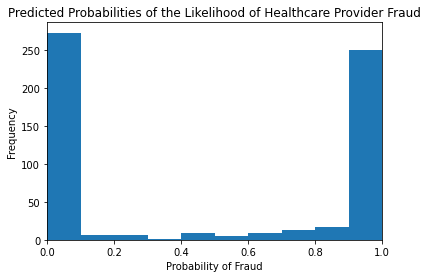

In [ ]:
# we're going to plot the RandomForest model and the probability dataframe based on the RF model 
# bc we want to visualize what the majority of our predictions will be
# first we need to pull the [1] index - potential fraud = 1
predict_fraud = rf.predict_proba(x_test)[:, 1]

# create histogram
plt.hist(predict_fraud, bins = 10)
plt.title("Predicted Probabilities of the Likelihood of Healthcare Provider Fraud")
plt.xlabel("Probability of Fraud")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.show()

## After examining the above histogram, we can confirm that there is slight positive skew in our histogram, therefore, confirming that there is a higher likelihood that no healthcare fraud is being committed in hospitals within the state of GA. 


> 


> 
